# The goal here is to do LSTM

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
df = pd.read_csv("/content/train_set.csv", error_bad_lines=None)
df = df.drop(['_temporary_index_column'],axis=1)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data preparation

In [ ]:
def scale_features(df):
  features = ["measurement_x", "measurement_y", "measurement_z"]

  # scaling between 0 and 1
  scaler = MinMaxScaler()
  df_scaled = pd.DataFrame(scaler.fit_transform(df[features]),
                                columns=features)
  df_scaled["patient_id"] = df["patient_id"]
  df_scaled["timestamp"] = pd.to_datetime(df["timestamp"])
  df_scaled['time'] = df_scaled['timestamp'].apply(lambda x: x.value)

  return df_scaled


In [ ]:
df_scaled = scale_features(df)
df_scaled.tail()

,measurement_x,measurement_y,measurement_z,patient_id,timestamp,time
196714,0.442588,0.411046,0.126160,6264,2012-10-29 09:35:14.445852,1351503314445852000
196715,0.444481,0.412395,0.129075,6264,2012-10-29 09:35:14.495852,1351503314495852000
196716,0.446362,0.413761,0.126896,6264,2012-10-29 09:35:14.545852,1351503314545852000
196717,0.448230,0.415142,0.136281,6264,2012-10-29 09:35:14.595852,1351503314595852000
196718,0.450086,0.416538,0.126688,6264,2012-10-29 09:35:14.645852,1351503314645852000


In [ ]:
max_seq_len = df_scaled.groupby("patient_id").count().max()["measurement_x"]
max_seq_len

101

In [ ]:
from tensorflow.keras.preprocessing import sequence

In [ ]:
# prepare a list with only measurements (a list rather than df) so we could use pad_sequences function from keras to get the same time serious length to all the patient_id

# sequence.pad_sequences(df_scaled, maxlen=max_seq_len)
from tqdm import tqdm
patient_ids = df_scaled['patient_id'].unique()

seqauences_scaled = []
for id in tqdm(patient_ids):
  sub_df = df_scaled[df_scaled["patient_id"] == id].drop(columns=["timestamp", "time", "patient_id"])
  seqauences_scaled.append(sub_df.values)

100%|██████████| 6265/6265 [00:05<00:00, 1098.85it/s]


In [ ]:
# do pad_sequences to get the same time serious length to all the patient_id
# Convert categorical labeled into dummy/indicator variables

X = sequence.pad_sequences(seqauences_scaled, maxlen=max_seq_len, dtype=np.float32)
y = pd.get_dummies(df.groupby("patient_id").first().label).values

print(X.shape)
print(y.shape)

(6265, 101, 3)
(6265, 3)


In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4197, 101, 3)
(4197, 3)
(2068, 101, 3)
(2068, 3)


# Building simple LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# do deep-learning optimizers, such as Adagrad, RMSProp, AdaDelta, and Adam.
batch_size = 32
epochs = 125

model = Sequential()
model.add(LSTM(10, input_shape=(max_seq_len, 3)))
model.add(Dense(3, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam")
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                560       
                                                                 
 dense (Dense)               (None, 3)                 33        
                                                                 
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs= epochs, batch_size = batch_size, verbose = 2)

Epoch 1/125
132/132 - 8s - loss: 0.8351 - val_loss: 0.6833 - 8s/epoch - 63ms/step
Epoch 2/125
132/132 - 1s - loss: 0.6232 - val_loss: 0.6156 - 926ms/epoch - 7ms/step
Epoch 3/125
132/132 - 1s - loss: 0.5135 - val_loss: 0.4634 - 894ms/epoch - 7ms/step
Epoch 4/125
132/132 - 1s - loss: 0.4306 - val_loss: 0.4671 - 931ms/epoch - 7ms/step
Epoch 5/125
132/132 - 1s - loss: 0.4228 - val_loss: 0.4124 - 914ms/epoch - 7ms/step
Epoch 6/125
132/132 - 1s - loss: 0.3925 - val_loss: 0.3927 - 891ms/epoch - 7ms/step
Epoch 7/125
132/132 - 1s - loss: 0.3889 - val_loss: 0.4034 - 1s/epoch - 8ms/step
Epoch 8/125
132/132 - 1s - loss: 0.3722 - val_loss: 0.3922 - 1s/epoch - 8ms/step
Epoch 9/125
132/132 - 1s - loss: 0.3581 - val_loss: 0.4899 - 1s/epoch - 9ms/step
Epoch 10/125
132/132 - 2s - loss: 0.3625 - val_loss: 0.3734 - 2s/epoch - 12ms/step
Epoch 11/125
132/132 - 1s - loss: 0.3509 - val_loss: 0.3630 - 1s/epoch - 9ms/step
Epoch 12/125
132/132 - 1s - loss: 0.3418 - val_loss: 0.3400 - 1s/epoch - 9ms/step
Epoch 13

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

Text(0, 0.5, 'Loss')

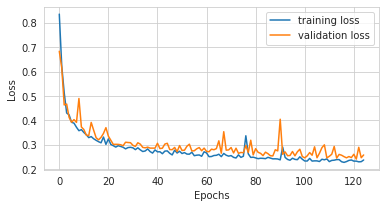

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [ ]:
y_test_pred = model.predict(X_test)

65/65 [==============================] - 1s 3ms/step


In [ ]:
y_test_pred.shape

(2068, 3)

In [ ]:
# toy example
# find the maximum value in the array
# need to convert back to the categorical variable
a = np.arange(9).reshape(3,3) + 1
print(a)
print(a.shape)
np.argmax(a, axis=1)

print(y_test.argmax(1))



[[1 2 3]
 [4 5 6]
 [7 8 9]]
(3, 3)
[1 0 1 ... 0 1 1]


In [ ]:
y_test.argmax(1)

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
print(y_test_pred)

[[1.2827347e-02 8.9211857e-01 9.5054068e-02]
 [9.9547285e-01 4.4717696e-03 5.5333163e-05]
 [2.1378317e-01 6.5614355e-01 1.3007328e-01]
 ...
 [9.9602425e-01 3.9259912e-03 4.9729329e-05]
 [2.6395256e-03 9.3297505e-01 6.4385451e-02]
 [1.2827347e-02 8.9211857e-01 9.5054068e-02]]


In [ ]:
from sklearn.metrics import classification_report

# find the maximum value in the array
y_test_pred_labeled = y_test_pred.argmax(1)
y_test_labeled = y_test.argmax(1)

print('\n LSTM classification report on test set')
print(classification_report(y_test_labeled, y_test_pred_labeled))


 LSTM classification report on test set
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1420
           1       0.77      0.85      0.81       508
           2       0.68      0.57      0.62       140

    accuracy                           0.90      2068
   macro avg       0.80      0.79      0.79      2068
weighted avg       0.90      0.90      0.90      2068



# print confusion matrix

In [ ]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


matrix = confusion_matrix(y_test_labeled, y_test_pred_labeled)
print("RandomForestClassifier Test Set \n Confusion Matrix: \n", matrix)

RandomForestClassifier Test Set 
 Confusion Matrix: 
 [[1341   74    5]
 [  42  433   33]
 [   5   55   80]]
